## 1. Conectar base de datos

In [81]:
from dotenv import load_dotenv
import os
import pandas as pd
from sqlalchemy import create_engine

# Cargar variables del .env
load_dotenv()

DATABASE_URL = os.getenv("DATABASE_URL")  

if DATABASE_URL is None:
    raise ValueError("No se encontró la variable DATABASE_URL en el archivo .env")

# Crear engine de SQLAlchemy
engine = create_engine(DATABASE_URL)

# Consulta de ventas diarias
query = """
SELECT 
    DATE("DATE_") AS date,
    SUM("TOTALBASKET") AS daily_sales
FROM public."Orders"
GROUP BY DATE("DATE_")
ORDER BY DATE("DATE_");
"""

df = pd.read_sql(query, engine)
df["date"] = pd.to_datetime(df["date"])
df = df.sort_values("date")

df.head()

,date,daily_sales
0,2021-01-01,5824909.56
1,2021-01-02,5893520.92
2,2021-01-03,5928126.70
3,2021-01-04,5725864.05
4,2021-01-05,5880175.52


MAE SARIMA: 182175.42827173218


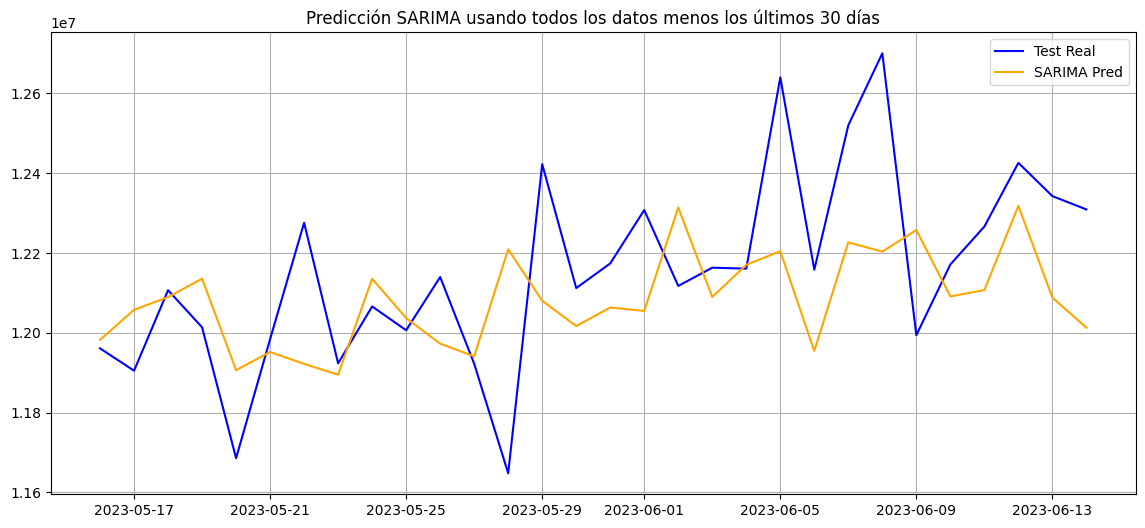

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error
import warnings
warnings.filterwarnings("ignore")

# -------------------------------
# 1. Preparar la serie temporal
# -------------------------------

df["date"] = pd.to_datetime(df["date"])
df = df.sort_values("date")

ts = df.set_index("date")["daily_sales"]

# -------------------------------
# 2. Separar train y test
# -------------------------------
train = ts.iloc[:-30]
test  = ts.iloc[-30:]

# -------------------------------
# 3. Entrenar el modelo SARIMA
# -------------------------------
model = SARIMAX(
    train,
    order=(2,1,2),
    seasonal_order=(1,1,1,30),   # estacionalidad mensual
    enforce_stationarity=False,
    enforce_invertibility=False
)

model_fit = model.fit(disp=False)

# -------------------------------
# 4. Predicción sobre el test
# -------------------------------
forecast = model_fit.forecast(steps=len(test))

# -------------------------------
# 5. Evaluación
# -------------------------------
mae = mean_absolute_error(test, forecast)
print("MAE SARIMA:", mae)

# -------------------------------
# 6. Visualización
# -------------------------------
plt.figure(figsize=(14,6))
plt.plot(train.index, train, label="Train")
plt.plot(test.index, test, label="Test Real", color="blue")
plt.plot(test.index, forecast, label="SARIMA Pred", color="orange")
plt.title("Predicción SARIMA usando todos los datos menos los últimos 30 días")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import pickle

# -------------------------------
# 1. Entrenar modelo completo
# -------------------------------
model_final = SARIMAX(
    ts,   # ahora usamos TODA la serie
    order=(2,1,2),
    seasonal_order=(1,1,1,30),
    enforce_stationarity=False,
    enforce_invertibility=False
)

model_final_fit = model_final.fit(disp=False)

# -------------------------------
# 2. Guardar el modelo en un archivo
# -------------------------------
with open("sarima_final_model.pkl", "wb") as f:
    pickle.dump(model_final_fit, f)

print("Modelo SARIMA guardado como sarima_final_model.pkl")


Modelo SARIMA guardado como sarima_final_model.pkl


MAE RandomForest: 3372120.3798017004


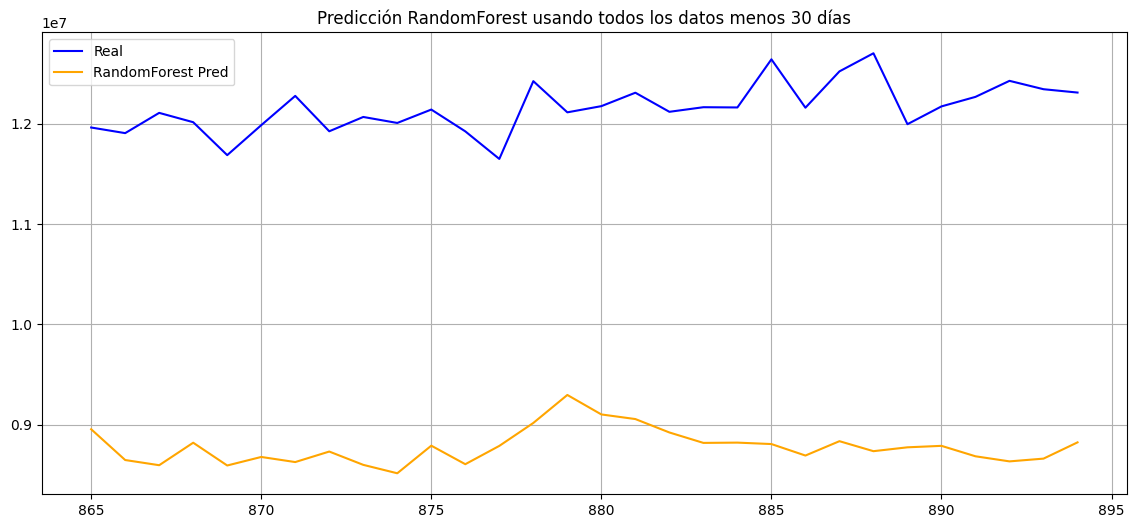

In [94]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
import warnings
warnings.filterwarnings("ignore")

# ============================
# 1. Preparar datos
# ============================

df["date"] = pd.to_datetime(df["date"])
df = df.sort_values("date")

# Variables temporales
df["day"]   = df.date.dt.day
df["month"] = df.date.dt.month
df["dow"]   = df.date.dt.dayofweek

# Variables cíclicas
df["day_sin"]   = np.sin(2*np.pi*df["day"]/31)
df["day_cos"]   = np.cos(2*np.pi*df["day"]/31)
df["month_sin"] = np.sin(2*np.pi*df["month"]/12)
df["month_cos"] = np.cos(2*np.pi*df["month"]/12)
df["dow_sin"]   = np.sin(2*np.pi*df["dow"]/7)
df["dow_cos"]   = np.cos(2*np.pi*df["dow"]/7)

features = [
    "day_sin","day_cos",
    "month_sin","month_cos",
    "dow_sin","dow_cos"
]

X = df[features]
y = df["daily_sales"]

# ============================
# 2. Train/Test split
# ============================

X_train = X.iloc[:-30]
X_test  = X.iloc[-30:]
y_train = y.iloc[:-30]
y_test  = y.iloc[-30:]

# ============================
# 3. Entrenar modelo
# ============================

rf = RandomForestRegressor(
    n_estimators=600,
    max_depth=12,
    min_samples_split=5,
    min_samples_leaf=3,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)

# ============================
# 4. Predicción
# ============================

pred_rf = rf.predict(X_test)

mae_rf = mean_absolute_error(y_test, pred_rf)
print("MAE RandomForest:", mae_rf)

# ============================
# 5. Visualización
# ============================

plt.figure(figsize=(14,6))
plt.plot(y_test.index, y_test.values, label="Real", color="blue")
plt.plot(y_test.index, pred_rf, label="RandomForest Pred", color="orange")
plt.legend()
plt.title("Predicción RandomForest usando todos los datos menos 30 días")
plt.grid(True)
plt.show()


In [91]:
import pickle

rf_final = RandomForestRegressor(
    n_estimators=600,
    max_depth=12,
    min_samples_split=5,
    min_samples_leaf=3,
    random_state=42,
    n_jobs=-1
)

rf_final.fit(X, y)

with open("random_forest_sales.pkl", "wb") as f:
    pickle.dump(rf_final, f)

print("Modelo RandomForest guardado como random_forest_sales.pkl")


Modelo RandomForest guardado como random_forest_sales.pkl


MAE XGBoost: 3523377.189333332


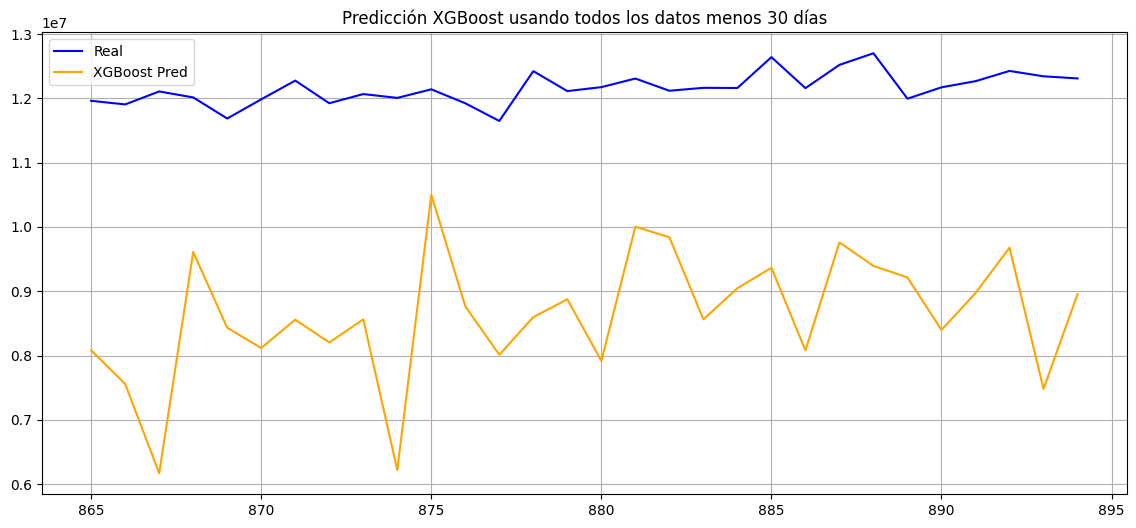

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
import warnings
warnings.filterwarnings("ignore")

# ============================
# 1. Preparar datos
# ============================

df["date"] = pd.to_datetime(df["date"])
df = df.sort_values("date")

# Variables temporales
df["day"]   = df.date.dt.day
df["month"] = df.date.dt.month
df["dow"]   = df.date.dt.dayofweek

# Variables cíclicas
df["day_sin"]   = np.sin(2*np.pi*df["day"]/31)
df["day_cos"]   = np.cos(2*np.pi*df["day"]/31)
df["month_sin"] = np.sin(2*np.pi*df["month"]/12)
df["month_cos"] = np.cos(2*np.pi*df["month"]/12)
df["dow_sin"]   = np.sin(2*np.pi*df["dow"]/7)
df["dow_cos"]   = np.cos(2*np.pi*df["dow"]/7)

features = [
    "day_sin","day_cos",
    "month_sin","month_cos",
    "dow_sin","dow_cos"
]

X = df[features]
y = df["daily_sales"]

# ============================
# 2. Train/Test split
# ============================

X_train = X.iloc[:-30]
X_test  = X.iloc[-30:]
y_train = y.iloc[:-30]
y_test  = y.iloc[-30:]

# ============================
# 3. Entrenar modelo XGBoost
# ============================

xgb = XGBRegressor(
    n_estimators=10000,
    learning_rate=0.05,
    max_depth=30,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

xgb.fit(X_train, y_train)

# ============================
# 4. Predicción
# ============================

forecast_xgb = xgb.predict(X_test)

# ============================
# 5. Evaluación
# ============================

mae_xgb = mean_absolute_error(y_test, forecast_xgb)
print("MAE XGBoost:", mae_xgb)

# ============================
# 6. Visualización
# ============================

plt.figure(figsize=(14,6))
plt.plot(y_test.index, y_test.values, label="Real", color="blue")
plt.plot(y_test.index, forecast_xgb, label="XGBoost Pred", color="orange")
plt.legend()
plt.title("Predicción XGBoost usando todos los datos menos 30 días")
plt.grid(True)
plt.show()


In [98]:
import pickle

# Entrenar con todos los datos completos
xgb_final = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=10,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

xgb_final.fit(X, y)

# Guardar modelo
with open("xgboost_sales_model.pkl", "wb") as f:
    pickle.dump(xgb_final, f)

print("Modelo XGBoost guardado como xgboost_sales_model.pkl")


Modelo XGBoost guardado como xgboost_sales_model.pkl


48/48 ━━━━━━━━━━━━━━━━━━━━ 20s 364ms/step - loss: 0.0307 - val_loss: 0.0028
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step
MAE LSTM: 170882.24312499957


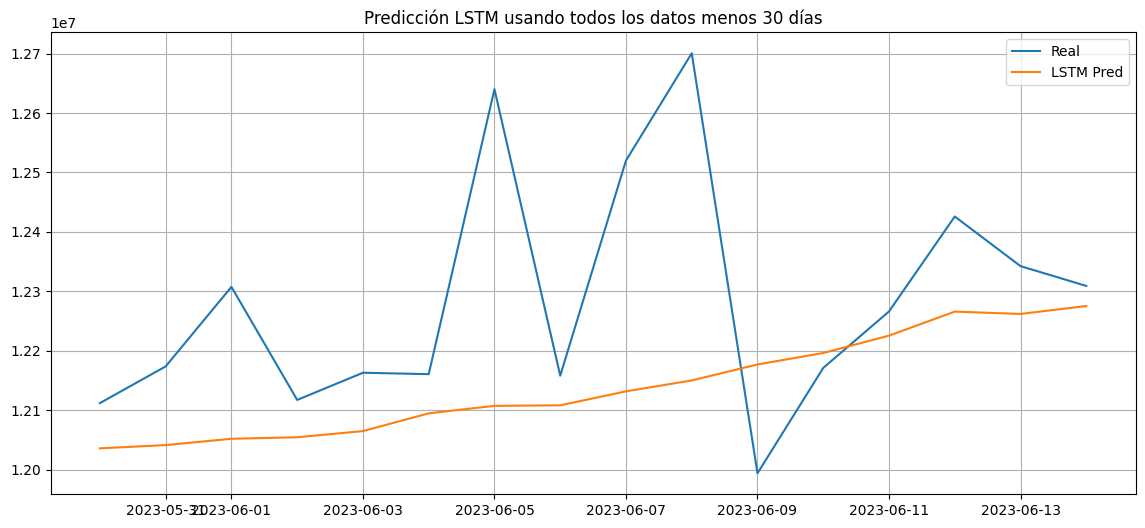

In [ ]:
# =========================================
# 1. Importaciones
# =========================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_absolute_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings("ignore")

# =========================================
# 2. Preparar los datos
# =========================================

df["date"] = pd.to_datetime(df["date"])
df = df.sort_values("date")

ts = df.set_index("date")["daily_sales"].astype(float)

# =========================================
# 3. Normalización (solo con train!)
# =========================================

train_ts = ts.iloc[:-30]
test_ts  = ts.iloc[-30:]

scaler = RobustScaler()
train_scaled = scaler.fit_transform(train_ts.values.reshape(-1,1))
test_scaled  = scaler.transform(test_ts.values.reshape(-1,1))

# =========================================
# 4. Crear secuencias (ventana temporal)
# =========================================

def create_sequences(data, window=14):
    X, y = [], []
    for i in range(len(data)-window):
        X.append(data[i:i+window])
        y.append(data[i+window])
    return np.array(X), np.array(y)

window = 14

X_train, y_train = create_sequences(train_scaled, window)
X_test,  y_test  = create_sequences(test_scaled, window)

# Ajustar dimensiones para LSTM (samples, timesteps, features)
X_train = X_train.reshape(X_train.shape[0], window, 1)
X_test  = X_test.reshape(X_test.shape[0], window, 1)

# =========================================
# 5. Definir el modelo LSTM
# =========================================


model = Sequential([
    
    # Capa 1 LSTM
    LSTM(1024, activation='tanh', return_sequences=True, input_shape=(window,1)),
    Dropout(0.2),

    # Capa 2 LSTM
    LSTM(512, activation='tanh', return_sequences=True),
    Dropout(0.2),

    # Capa 3 LSTM final
    LSTM(256, activation='tanh', return_sequences=False),
    Dropout(0.2),

    # Capas densas de refinamiento
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(1)
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
    loss='mse'
)

# =========================================
# 6. Entrenamiento
# =========================================

history = model.fit(
    X_train, y_train,
    epochs=1,
    batch_size=16,
    validation_split=0.1,
    verbose=1
)

# =========================================
# 7. Predicción y desescalado
# =========================================

pred_scaled = model.predict(X_test)
pred_lstm = scaler.inverse_transform(pred_scaled)
y_test_real = scaler.inverse_transform(y_test)

# =========================================
# 8. Evaluación
# =========================================

mae_lstm = mean_absolute_error(y_test_real, pred_lstm)
print("MAE LSTM:", mae_lstm)

# =========================================
# 9. Visualización
# =========================================

plt.figure(figsize=(14,6))
plt.plot(test_ts.index[-len(pred_lstm):], y_test_real, label="Real")
plt.plot(test_ts.index[-len(pred_lstm):], pred_lstm, label="LSTM Pred")
plt.title("Predicción LSTM usando todos los datos menos 30 días")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# =========================================
# 1. Normalizar toda la serie
# =========================================

# Usamos de nuevo RobustScaler para mantener coherencia
scaler_full = RobustScaler()
ts_scaled = scaler_full.fit_transform(ts.values.reshape(-1,1))

# Volvemos a crear la función de secuencias 
def create_sequences(data, window=14):
    X, y = [], []
    for i in range(len(data)-window):
        X.append(data[i:i+window])
        y.append(data[i+window])
    return np.array(X), np.array(y)

window = 14  

# Crear secuencias para TODO el dataset
X_full, y_full = create_sequences(ts_scaled, window)

# Dimensionar para LSTM
X_full = X_full.reshape(X_full.shape[0], window, 1)


# =========================================
# 2. Definir el mismo modelo LSTM que usaste
# =========================================

model_final = Sequential([
    
    LSTM(1024, activation='tanh', return_sequences=True, input_shape=(window,1)),
    Dropout(0.2),

    LSTM(512, activation='tanh', return_sequences=True),
    Dropout(0.2),

    LSTM(256, activation='tanh', return_sequences=False),
    Dropout(0.2),

    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(1)
])

model_final.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
    loss='mse'
)

# =========================================
# 3. Entrenar con TODOS los datos
# =========================================

history_final = model_final.fit(
    X_full, y_full,
    epochs=1,       
    batch_size=16,
    verbose=1
)

# =========================================
# 4. Guardar modelo + scaler
# =========================================

model_final.save("lstm_sales_model.h5")

import pickle
with open("lstm_scaler.pkl", "wb") as f:
    pickle.dump(scaler_full, f)

print("Modelo LSTM guardado como lstm_sales_model.h5")
print("Scaler guardado como lstm_scaler.pkl")


56/56 ━━━━━━━━━━━━━━━━━━━━ 22s 353ms/step - loss: 0.0286


Modelo LSTM guardado como lstm_sales_model.h5
Scaler guardado como lstm_scaler.pkl
